In [339]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as deepcopy
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [341]:
data = pd.read_csv('Bitcoin.csv')
data = data.drop('Market Cap', axis=1) #dropping columns because I want to limit entry and using two different datasets and I need to make them similar
data

,Date,Open,High,Low,Close,Volume
0,28-05-2021,38507.083075,38856.967885,34779.039427,35697.606390,5.520019e+10
1,27-05-2021,39316.889678,40379.617672,37247.903676,38436.968535,4.321097e+10
2,26-05-2021,38392.623656,40782.078183,37905.834854,39294.197382,5.134674e+10
3,25-05-2021,38795.780250,39776.349798,36581.428916,38402.223851,5.621192e+10
4,24-05-2021,34700.363568,39835.139830,34551.080550,38705.978637,6.735958e+10
...,...,...,...,...,...,...
2948,02-05-2013,116.379997,125.599998,92.281898,105.209999,0.000000e+00
2949,01-05-2013,139.000000,139.889999,107.720001,116.989998,0.000000e+00
2950,30-04-2013,144.000000,146.929993,134.050003,139.000000,0.000000e+00
2951,29-04-2013,134.444000,147.488007,134.000000,144.539993,0.000000e+00


C:\Users\wesley.rennie\AppData\Local\Temp\ipykernel_34544\1993489308.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


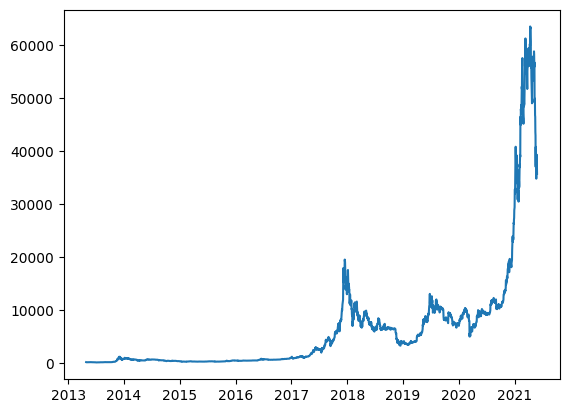

In [342]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close']) 

In [343]:
data['volitility'] = data['High'] - data['Low'] 


In [344]:
data['return'] = np.log(data['Close'] / data['Close'].shift(1)) # data['Close'] - data['Open']
data['direction'] = np.where(data['return'] > 0, 1, 0)
data

,Date,Open,High,Low,Close,Volume,volitility,return,direction
0,2021-05-28,38507.083075,38856.967885,34779.039427,35697.606390,5.520019e+10,4077.928458,NaN,0
1,2021-05-27,39316.889678,40379.617672,37247.903676,38436.968535,4.321097e+10,3131.713995,0.073936,1
2,2021-05-26,38392.623656,40782.078183,37905.834854,39294.197382,5.134674e+10,2876.243330,0.022057,1
3,2021-05-25,38795.780250,39776.349798,36581.428916,38402.223851,5.621192e+10,3194.920882,-0.022961,0
4,2021-05-24,34700.363568,39835.139830,34551.080550,38705.978637,6.735958e+10,5284.059280,0.007879,1
...,...,...,...,...,...,...,...,...,...
2948,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,33.318100,0.073545,1
2949,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,32.169998,0.106130,1
2950,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,12.879990,0.172385,1
2951,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,13.488007,0.039082,1


In [345]:
data = data.drop('Open', axis = 1)
data = data.drop( 'High', axis = 1)
data = data.drop( 'Low', axis = 1)
data # dropping columns

,Date,Close,Volume,volitility,return,direction
0,2021-05-28,35697.606390,5.520019e+10,4077.928458,NaN,0
1,2021-05-27,38436.968535,4.321097e+10,3131.713995,0.073936,1
2,2021-05-26,39294.197382,5.134674e+10,2876.243330,0.022057,1
3,2021-05-25,38402.223851,5.621192e+10,3194.920882,-0.022961,0
4,2021-05-24,38705.978637,6.735958e+10,5284.059280,0.007879,1
...,...,...,...,...,...,...
2948,2013-05-02,105.209999,0.000000e+00,33.318100,0.073545,1
2949,2013-05-01,116.989998,0.000000e+00,32.169998,0.106130,1
2950,2013-04-30,139.000000,0.000000e+00,12.879990,0.172385,1
2951,2013-04-29,144.539993,0.000000e+00,13.488007,0.039082,1


In [346]:
#reversing dataframe and then having a lookback function for 7 days
data = data.iloc[::-1]
def prepare_dataframe_for_lstm(df, n_steps):
    df = deepcopy(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df
#***change how many dates going back
lookback = 7 # The lookback defines how many days in the past we want to consider.
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df


,Close,Volume,volitility,return,direction,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,,,
2013-05-05,115.910004,0.000000e+00,11.657005,0.031640,1,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,112.300003,0.000000e+00,18.023003,0.007149,1,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993
2013-05-07,111.500000,0.000000e+00,15.744003,-0.018360,0,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000
2013-05-08,113.566002,0.000000e+00,6.180000,0.007921,1,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998
2013-05-09,112.669998,0.000000e+00,4.199997,-0.039419,0,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23,34770.583623,7.846927e+10,7061.878688,-0.107222,0,37536.631112,37304.690671,40782.738262,37002.440466,42909.400925,43537.511389,46456.058474
2021-05-24,38705.978637,6.735958e+10,5284.059280,0.007879,1,34770.583623,37536.631112,37304.690671,40782.738262,37002.440466,42909.400925,43537.511389
2021-05-25,38402.223851,5.621192e+10,3194.920882,-0.022961,0,38705.978637,34770.583623,37536.631112,37304.690671,40782.738262,37002.440466,42909.400925


In [347]:
# shifted_df['momentum'] = data['return'].rolling(lookback).mean().shift(1)

In [348]:
#creating my test data from yahoo finance to mimic training data but different time frame
import yfinance as yf

symbol = 'BTC-USD'
raw = yf.download(symbol, start='2021-06-01', end='2024-05-09')

test_data = pd.DataFrame(raw)
test_data['volitility'] = test_data['High'] - test_data['Low']
test_data['return'] = np.log(test_data['Close'] / test_data['Close'].shift(1)) # data['Close'] - data['Open']
test_data['direction'] = np.where(test_data['return'] > 0, 1, 0)
test_data = test_data.drop('Open', axis = 1)
test_data = test_data.drop('High', axis = 1)
test_data = test_data.drop('Low', axis = 1)
test_data = test_data.drop('Adj Close', axis = 1)
# test_data = test_data.iloc[::-1]
#***change how many dates going back
lags = 7 # The lookback defines how many days in the past we want to consider.
for lag in range(1, lags+1):
    col = f'Close({lag})'
    test_data[col] = test_data['Close'].shift(lag)
test_data.dropna(inplace=True)
test_data



[*********************100%%**********************]  1 of 1 completed


,Close,Volume,volitility,return,direction,Close(1),Close(2),Close(3),Close(4),Close(5),Close(6),Close(7)
Date,,,,,,,,,,,,
2021-06-08,33472.632812,49902050442,2902.943359,-0.002628,0,33560.707031,35862.378906,35551.957031,36894.406250,39208.765625,37575.179688,36684.925781
2021-06-09,37345.121094,53972919008,5061.505859,0.109474,1,33472.632812,33560.707031,35862.378906,35551.957031,36894.406250,39208.765625,37575.179688
2021-06-10,36702.597656,43576032854,2486.730469,-0.017355,0,37345.121094,33472.632812,33560.707031,35862.378906,35551.957031,36894.406250,39208.765625
2021-06-11,37334.398438,38699736985,1564.246094,0.017068,1,36702.597656,37345.121094,33472.632812,33560.707031,35862.378906,35551.957031,36894.406250
2021-06-12,35552.515625,37924228550,2680.734375,-0.048904,0,37334.398438,36702.597656,37345.121094,33472.632812,33560.707031,35862.378906,35551.957031
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03,62889.835938,33172023048,4472.191406,0.061757,1,59123.433594,58254.011719,60636.855469,63841.121094,63113.230469,63419.140625,63755.320312
2024-05-04,63891.472656,20620477992,1895.605469,0.015801,1,62889.835938,59123.433594,58254.011719,60636.855469,63841.121094,63113.230469,63419.140625
2024-05-05,64031.132812,18296164805,1655.585938,0.002184,1,63891.472656,62889.835938,59123.433594,58254.011719,60636.855469,63841.121094,63113.230469


In [349]:
#shifting data into numpy and preparing it into a tensor
shifted_df_as_np = shifted_df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np.shape

(2945, 12)

In [350]:
test_data_as_np = test_data.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
test_data_as_np = scaler.fit_transform(test_data_as_np)
test_data_as_np.shape

(1065, 12)

In [351]:
X = shifted_df_as_np[:, 1:]
X = deepcopy(np.flip(X, axis=1))
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2945, 11), (2945,))

In [352]:
xt = test_data_as_np[:, 1:]
X_test = deepcopy(np.flip(xt, axis=1))
y_test = test_data_as_np[:, 0]

X_test.shape, y_test.shape

((1065, 11), (1065,))

In [353]:
split_index = 1276 #1641

X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1276, 11), (1669, 11), (1276,), (1669,))

In [354]:
lb = 11
X_train = X_train.reshape((-1, lb, 1))
X_val = X_val.reshape((-1, lb, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1276, 11, 1), (1669, 11, 1), (1276, 1), (1669, 1))

In [355]:
X_test = X_test.reshape((-1, lb, 1))
y_test = y_test.reshape((-1, 1))
X_test.shape, y_test.shape

((1065, 11, 1), (1065, 1))

In [356]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([1276, 11, 1]),
 torch.Size([1669, 11, 1]),
 torch.Size([1276, 1]),
 torch.Size([1669, 1]))

In [357]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_test.shape, X_test.shape

(torch.Size([1065, 11, 1]), torch.Size([1065, 11, 1]))

In [358]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

print(test_dataset)

In [359]:
batch_size = 8
#do I want shuffle or no?
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_load = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [360]:
#intializing lstm class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # Call the constructor of the parent class (nn.Module)
        super().__init__()

        # Initialize attributes for hidden size and number of stacked layers
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Define the LSTM layer
        # Parameters:
        # - input_size: The number of expected features in the input x
        # - hidden_size: The number of features in the hidden state h
        # - num_stacked_layers: Number of recurrent layers (stacked together)
        # - batch_first: If True, input and output tensors are provided as (batch_size, sequence_length, feature_dim)
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        # Define the fully connected (linear) layer
        # Parameters:
        # - in_features: The size of each input sample (hidden_size of LSTM)
        # - out_features: The size of each output sample (1, predicting one value)
        self.fc = nn.Linear(hidden_size, 1)

  
    def forward(self, x):
        # TODO: Get the batch size
        # Hint: In PyTorch the batch size corresponds to the size of the first dimension of the input tensor x.       
        batch_size = x.size(0)

        # Initialize the initial hidden state and cell state of the LSTM
        # All zeros, with shape (num_stacked_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        #**add more hn (consider fully connected)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)

        # Pass the input sequence through the LSTM layer
        # The LSTM takes input x and initial hidden/cell states (h0, c0)
        out, _ = self.lstm(x, (h0, c0))
        
        # Take only the last time step output from the LSTM
        # The output shape is (batch_size, sequence_length, hidden_size)
        # We take out[:, -1, :] to get the output at the last time step for each batch
        # This reduces the output shape to (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        
        # Return the output
        return out


In [361]:
#creating model with 1 input 10 hidden layers and 1 output 
model = LSTM(1, 10, 1)
model

LSTM(
  (lstm): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [362]:
def train_one_epoch(epoch, optimizer, model, loss_function, train_loader):
    model.train(True) 
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [363]:
def validate_one_epoch(model, loss_function, test_loader):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [364]:
learning_rate = 0.002
num_epochs = 200
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch = epoch, optimizer = optimizer, model = model, loss_function = loss_function, train_loader = train_loader)
    validate_one_epoch(model = model, loss_function = loss_function, test_loader = val_loader)

Epoch: 1
Batch 100, Loss: 0.268

Val Loss: 0.195
***************************************************

Epoch: 2
Batch 100, Loss: 0.000

Val Loss: 0.203
***************************************************

Epoch: 3
Batch 100, Loss: 0.000

Val Loss: 0.210
***************************************************

Epoch: 4
Batch 100, Loss: 0.000

Val Loss: 0.216
***************************************************

Epoch: 5
Batch 100, Loss: 0.000

Val Loss: 0.221
***************************************************

Epoch: 6
Batch 100, Loss: 0.000

Val Loss: 0.225
***************************************************

Epoch: 7
Batch 100, Loss: 0.000

Val Loss: 0.229
***************************************************

Epoch: 8
Batch 100, Loss: 0.000

Val Loss: 0.232
***************************************************

Epoch: 9
Batch 100, Loss: 0.000

Val Loss: 0.234
***************************************************

Epoch: 10
Batch 100, Loss: 0.000

Val Loss: 0.235
********************************

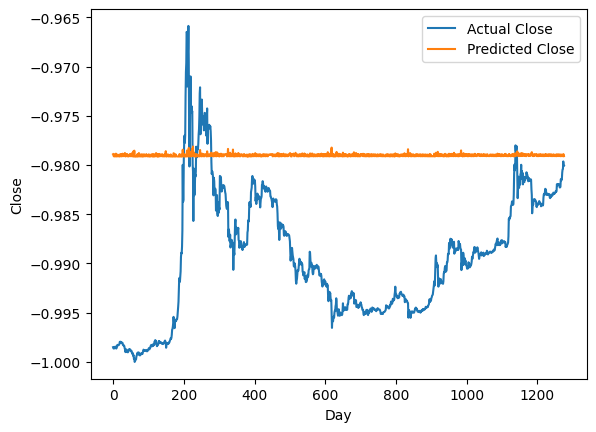

In [365]:
#plotting model with training data
with torch.no_grad():
    predicted = model(X_train).numpy()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

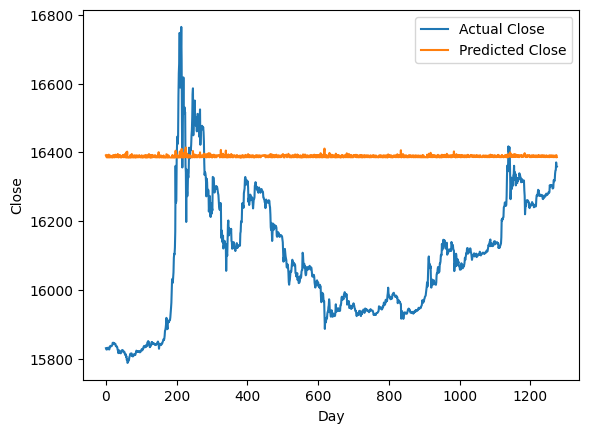

In [366]:
# Flatten the predicted values obtained from the model
train_predictions = predicted.flatten()

# Create a placeholder array to hold the scaled data
scaled = np.zeros((X_train.shape[0], lb+1))

# Assign the predicted values to the first column of the scaled array
scaled[:, 0] = train_predictions

# Invert the scaling to obtain the original values
scaled = scaler.inverse_transform(scaled)

# Deepcopy the scaled predicted values to prevent modification
train_predictions = deepcopy(scaled[:, 0])

# Reset the scaled array to hold the true training values
scaled = np.zeros((X_train.shape[0], lb+1))

# Assign the true training values to the first column of the scaled array
scaled[:, 0] = y_train.flatten()

# Invert the scaling to obtain the original true values
scaled = scaler.inverse_transform(scaled)

# Deepcopy the scaled true training values to prevent modification
new_y_train = deepcopy(scaled[:, 0])

# Plot the actual close prices against the predicted close prices for training data
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

[[1.63869264e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.63952166e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.63872252e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 ...
 [1.68509593e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.68185072e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.67563964e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]]


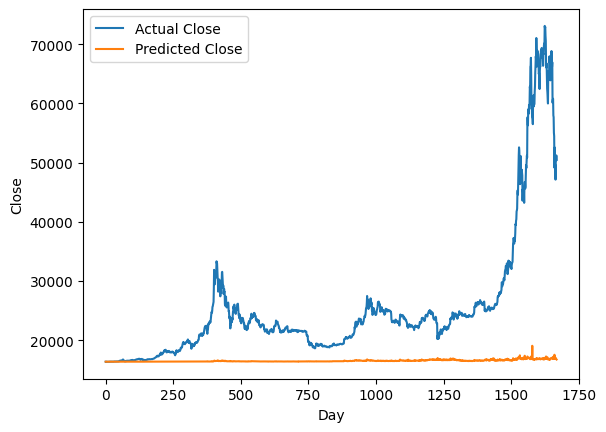

In [367]:
# Generate predictions using the trained model on the test data
test_predictions = model(X_val).detach().cpu().numpy().flatten()

# Create a placeholder array to hold the scaled data
scaled = np.zeros((X_val.shape[0], 12))

# Assign the predicted values to the first column of the scaled array
scaled[:, 0] = test_predictions

# Invert the scaling to obtain the original values
scaled = scaler.inverse_transform(scaled)
test_predictions = deepcopy(scaled[:, 0])
print(scaled)

# Reset the scaled array to hold the true test values
scaled = np.zeros((X_val.shape[0], 12))
scaled[:, 0] = y_val.flatten()

# Invert the scaling to obtain the original true values
scaled = scaler.inverse_transform(scaled)

new_y_test = deepcopy(scaled[:, 0])

# Plot the actual close prices against the predicted close prices
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

[[1.75324245e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.76960378e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.73675732e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 ...
 [1.67334672e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.69873405e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]
 [1.69136695e+04 6.21618192e+10 5.54544434e+03 ... 4.44353921e+04
  4.44353921e+04 4.44353921e+04]]


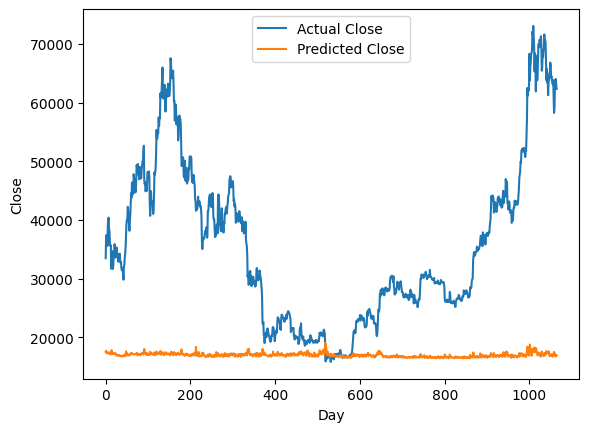

In [368]:
# Generate predictions using the trained model on the test data
test_predictions = model(X_test).detach().cpu().numpy().flatten()

# Create a placeholder array to hold the scaled data
scaled = np.zeros((X_test.shape[0], 12))

# Assign the predicted values to the first column of the scaled array
scaled[:, 0] = test_predictions

# Invert the scaling to obtain the original values
scaled = scaler.inverse_transform(scaled)
test_predictions = deepcopy(scaled[:, 0])
print(scaled)

# Reset the scaled array to hold the true test values
scaled = np.zeros((X_test.shape[0], 12))
scaled[:, 0] = y_test.flatten()

# Invert the scaling to obtain the original true values
scaled = scaler.inverse_transform(scaled)

new_y_test = deepcopy(scaled[:, 0])

# Plot the actual close prices against the predicted close prices
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()